## Classification of CNN News Articles

Project Objective: To correctly classify the type of news article

Dataset Source: https://www.kaggle.com/datasets/hadasu92/cnn-articles-after-basic-cleaning

##### Import Necessary Libraries

In [0]:
import pyspark

from pyspark.ml import Pipeline
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, StructType, StructField, IntegerType, TimestampType
from pyspark.ml.feature import StringIndexer, IndexToString

import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#### Create Functions That Are Used in This Project

##### Create Function for Data Ingestion

In [0]:
def import_ds(file_location: str, schema: StructType):
    '''
    This function imports a single dataset (or file) at a time. 
    It also drops samples with null values.
    '''
    file_type = "csv"
    
    # CSV options
    infer_schema = "false"
    first_row_is_header = "true"
    delimiter = ","
    
    df = spark.read.format(file_type) \
      .option("inferSchema", infer_schema) \
      .option("header", first_row_is_header) \
      .option("sep", delimiter) \
      .schema(schema)\
      .load(file_location)
    
    df = df.na.drop()
    
    return df

##### Create Functions for Commonly Used Preprocessing Actions Used in This Project (Each Function in Individual Command Block)

In [0]:
def drop_unnecessary_features(dataset: pyspark.sql.dataframe.DataFrame) -> pyspark.sql.dataframe.DataFrame:
    '''
    This function removes unneeded features (as shown in the 'drop' statement).
    '''
    dataset = dataset.drop("Index", "Author", \
                           "Date published", "Description", \
                           "Section", "Url", "Keywords", \
                           "Headline", "Second headline")
    return dataset

In [0]:
def remove_leading_chars(dataset: pyspark.sql.dataframe.DataFrame, \
                         column_name: str, \
                         char_to_remove: str = " "\
                        ) -> pyspark.sql.dataframe.DataFrame:
    '''
    This function removes leading characters (which are passed in as 'char_to_remove') from 
    '''
    dataset = dataset.withColumn(column_name, F.regexp_replace(column_name, f"^[{char_to_remove}]*", ''))
    return dataset

In [0]:
def replace_character(dataset: pyspark.sql.dataframe.DataFrame, \
                         column_name: str, \
                         char_to_remove: str = "",\
                         char_to_insert: str = "" \
                        ) -> pyspark.sql.dataframe.DataFrame:
    '''
    This function removes leading characters (which are passed in as 'char_to_remove') from 
    '''
    dataset = dataset.withColumn(column_name, \
                                 F.regexp_replace(column_name, \
                                                  char_to_remove, \
                                                  char_to_insert))
    return dataset

In [0]:
def add_text_length_column(dataset: pyspark.sql.dataframe.DataFrame, \
                           what_column: str, \
                           new_col_name: str\
                          ) -> pyspark.sql.dataframe.DataFrame:
    '''
    This function adds a column that calculates & displays the length of the
    column that is passed in ('what_column').
    '''
    dataset = dataset.withColumn(new_col_name, F.size(F.split(F.col(what_column), " ")))
    return dataset

In [0]:
def filter_labels(dataset: pyspark.sql.dataframe.DataFrame, \
                  label_vals_to_keep: [str], \
                  label_col_name: str = "label"\
                 ) -> pyspark.sql.dataframe.DataFrame:
    '''
    This function removes samples with unwanted values in the label column.
    '''
    filtered_df = dataset.filter(dataset[label_col_name].isin(label_vals_to_keep))
    return filtered_df

##### Create Function to Remove Class Imbalance

In [0]:
def balance_dataset(dataset: pyspark.sql.dataframe.DataFrame, \
                    unique_label_values: [str], \
                    new_schema: StructType, \
                    samples: int = 20000, \
                    label_col: str = "label") -> pyspark.sql.dataframe.DataFrame:
    '''
    This function balances the classes in the dataset that is passed to this function.
    '''
    temp_df =  spark.createDataFrame([], new_schema)
    new_df =  spark.createDataFrame([], new_schema)
    
    for ulab in unique_label_values:
        # extract df of only the desired labels
        temp_df = dataset.where(F.col(label_col).isin(ulab))

        ratio = round(samples/temp_df.count(), 4)

        # sample it to desired number of samples
        if ratio > 1.0:
            # Oversample
            temp_df = temp_df.sample(True, ratio, seed=42)
        elif ratio < 1.0:
            # Undersample
            temp_df = temp_df.sample(False, ratio, seed=42)
        elif ratio == 1.0:
            # Just use the existing dataframe
            pass
        # concatenate it to the new_df
        new_df = new_df.union(temp_df)
        # unpersist the temp_df
        temp_df.unpersist()
    return new_df

##### Create Function to evaluate & Display Metrics

In [0]:
def metrics_eval(prediction, \
                 label, \
                 model_name: str
                ) -> None:
    '''
    This function calculates and displays the following metrics:
    - Classification Report (including accuracy, recall, precision, 
        & F1-score, among others)
    - Confusion Matrix
    '''
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
    print("-------------------------------------------------------------")
    print(f"The {model_name} Model:")
    print("-------------------------------------------------------------")
    print(f"Classification Report for the {model_name} Model:")
    
    report = classification_report(label, prediction, zero_division=1)
    print(report)
    
    print("-------------------------------------------------------------")
    
    print(f"Confusion Matrix for the {model_name} Model:")
    cm = confusion_matrix(label, prediction)
    dist = ConfusionMatrixDisplay(confusion_matrix=cm)
    dist.plot()
    
    print("-------------------------------------------------------------")

#### Ingest & Preprocess Data

##### Ingest Training Dataset

In [0]:
training_schema = StructType([
    StructField("Index", IntegerType(), True),
    StructField("Author", StringType(), True),
    StructField("Date published", TimestampType(), True),
    StructField("Category", StringType(), True),
    StructField("Section", StringType(), True),
    StructField("Url", StringType(), True),
    StructField("Headline", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Keywords", StringType(), True),
    StructField("Second headline", StringType(), True),
    StructField("Article text", StringType(), True),
])

file_location = "/FileStore/tables/CNN News Articles from 2011 to 2022/CNN_Articles_clean_LG.csv"

train_ds = import_ds(file_location, training_schema)

train_ds.printSchema()

root
 |-- Index: integer (nullable = true)
 |-- Author: string (nullable = true)
 |-- Date published: timestamp (nullable = true)
 |-- Category: string (nullable = true)
 |-- Section: string (nullable = true)
 |-- Url: string (nullable = true)
 |-- Headline: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Keywords: string (nullable = true)
 |-- Second headline: string (nullable = true)
 |-- Article text: string (nullable = true)



##### Preprocess Training Dataset

In [0]:
train_ds = drop_unnecessary_features(train_ds)

train_ds = remove_leading_chars(train_ds, "Article text", "\"")
train_ds = remove_leading_chars(train_ds, "Article text", " ")

train_ds = replace_character(train_ds, "Article text", '\"\"', "\"")

labels_to_use = ["business", "entertainment", "health", "news", "politics"]
train_ds = filter_labels(train_ds, labels_to_use, "Category")

bal_ds_schema = StructType([
    StructField("Category", StringType(), True),
    StructField("Article text", StringType(), True),
])

train_ds = balance_dataset(train_ds,\
                    labels_to_use,\
                    bal_ds_schema,\
                    samples=2000,\
                    label_col="Category")

##### Continue Preprocessing Training Dataset

In [0]:
train_ds = add_text_length_column(train_ds, "Article text", "article_len")

display(train_ds)

Category Article text article_len business The pandemic thrust the working world into a new reality in March 2020 as offices closed and millions of people were forced to learn how to do their jobs from home.Two years later, employers and workers are still adapting to a new normal and trying to figure out what the future of work might look like.Some companies are determined to return to the way things were and get everyone back into the office. And some have embraced remote work, allowing employees to work from home full time or part of the time.But many workers are deciding to chart their own course. Some have found that they love working from home and never want to step foot in an office again. Others are itching to go back -- missing the in-person collaboration and socializing with peers. And some want a little bit of both worlds. That has prompted many workers to rethink or even switch careers and make some other big changes. Here's a look at how the pandemic reshaped people's careers in ways they never expected: Read MoreMoving cross country to start a new lifeAfter her job went fully remote, Chelsea Pruitt decided to move from California to Alabama. Chelsea Pruitt, 31, has lived in California for nearly her entire life. Now, she's headed to Alabama. Prior to the pandemic, Pruitt had thought about moving, but it wasn't until she started working remotely that the decision became a lot easier to make. "I feel like my chapter in life in San Francisco is changing 255 business New York (CNN Business)March Madness isn't just for college basketball fans. That phrase is also an apt description of the volatility on Wall Street, and this March is no different.Just look at what stocks have done so far this month. It began with worries about Russia's invasion of Ukraine and the spike in oil and gas prices. The Dow plunged nearly 800 points on March 7 as energy prices surged.And if that weren't enough, the market was girding itself for the Federal Reserve's first rate hike since late 2018. The Dow was down nearly 4% for the month as of March 8. JUST WATCHEDPrice of oil drops below $100. That's good news for gas pricesReplayMore Videos ...MUST WATCHPrice of oil drops below $100. That's good news for gas prices 02:30It has since come roaring back and is now up 2.5% in March. The S&P 500 has risen 2%. The tech-heavy Nasdaq has gained 1%. At one point this month, the index plummeted as much as 9%.March has often been a dramatic month for stocks. The dot-com boom of the late 1990s ended in March 2000 when the Nasdaq peaked and subsequently crashed more than 10% that month. Read MoreAnd just two years ago, stocks plunged in March after the beginning of the Covid-19 outbreak in America ground the US economy to a halt. Hopeful signs despite awful start to the month?The Great Recession (aka the 2008 Global Financial Crisis) peaked in March 2009. Stocks bottomed that month, after a nearly 60% decline from a high in October 2007, putting an end to a brutal bear market.If you have the stomach for it, you can do reasonably well in March. According to data from Yardeni Research, which looked into returns dating back to 1928, the S&P 500 on average rises 0.5% in the month. Stocks have gone up 57 times in March during that time frame and have fallen 37 times.Covid. War. Inflation. Recession fears. The stock market can't keep upLPL Financial chief market strategist Ryan Detrick looked back at how the S&P 500 fared in the 17 times since 1957 when the market fell in January and February and found that stocks usually rebound. The S&P 500 rose by an average of 1.1% in March of those years and wound up with a nearly 4% gain over the final 10 months following the drops in January and February."Seeing the first two months of a new year in the red isn't a great feeling 413 business New York (CNN Business)March Madness isn't just for college basketball fans. That phrase is also an apt description of the volatility on Wall Street, and this March is no different.

##### Trim Dataset Based on Article Length & Complete Preprocessing of Testing Dataset

In [0]:
train_ds = train_ds.filter(F.col("article_len") < 326)
train_ds = train_ds.filter(F.col("article_len") > 2)

train_ds = train_ds.drop("article_len")

train_ds = train_ds.withColumnRenamed("Category", "label")\
    .withColumnRenamed("Article text", "text")

train_ds.count()

Out[13]: 9333

##### Ingest Testing Dataset

In [0]:
test_ds_file = "/FileStore/tables/CNN News Articles from 2011 to 2022/CNN_Articles_clean_sm.csv"

testing_schema = StructType([
    StructField("Index", IntegerType(), True),
    StructField("Author", StringType(), True),
    StructField("Date published", TimestampType(), True),
    StructField("Category", StringType(), True),
    StructField("Section", StringType(), True),
    StructField("Url", StringType(), True),
    StructField("Headline", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Keywords", StringType(), True),
    StructField("Second headline", StringType(), True),
    StructField("Article text", StringType(), True),
])

test_ds = import_ds(test_ds_file, testing_schema)

test_ds.printSchema()

root
 |-- Index: integer (nullable = true)
 |-- Author: string (nullable = true)
 |-- Date published: timestamp (nullable = true)
 |-- Category: string (nullable = true)
 |-- Section: string (nullable = true)
 |-- Url: string (nullable = true)
 |-- Headline: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Keywords: string (nullable = true)
 |-- Second headline: string (nullable = true)
 |-- Article text: string (nullable = true)



##### Preprocess Testing Dataset

In [0]:
test_ds = drop_unnecessary_features(test_ds)

test_ds = remove_leading_chars(test_ds, "Article text", "\"")
test_ds = remove_leading_chars(test_ds, "Article text", " ")

keep_these_labels = ["business", "entertainment", "health", "news", "politics"]

test_ds = filter_labels(test_ds, keep_these_labels, "Category")
test_ds = replace_character(test_ds, "Article text", '\"\"', "\"")

display(test_ds)

Category Article text news (CNN)Right now, there's a shortage of truck drivers in the US and worldwide, exacerbated by the e-commerce boom brought on by the pandemic. One solution to the problem is autonomous trucks, and several companies are in a race to be the first to launch one. Among them is San Diego-based TuSimple.Founded in 2015, TuSimple has completed about 2 million miles of road tests with its 70 prototype trucks across the US, China and Europe. Although these are simply commercially available trucks retrofitted with its technology, TuSimple has deals in place with two of the world's largest truck manufacturers -- Navistar in the US and Traton, Volkswagen's trucking business, in Europe -- to design and build fully autonomous models, which it hopes to launch by 2024. Photos: The Yara Birkeland is what its builders call the world's first zero-emission, autonomous cargo ship. The ship is scheduled to make its first journey between two Norwegian towns before the end of the year. Click through to see more forms of transport set to transform the future.Hide Caption 1 of 13 Photos: Pictured here as a rendering, Oceanbird is a wind-powered transatlantic car carrier that cuts carbon emissions by 90%, compared to a standard car carrier.Hide Caption 2 of 13 Photos: It's not just maritime ships that are going green. Cities around the world are adopting electric ferries. Norwegian startup Zeabuz hopes its self-driving electric ferry (pictured here as a rendering) will help revive urban waterways.Hide Caption 3 of 13 Photos: In China, a new Maglev high-speed train rolls off the production line in Qingdao, east China's Shandong Province, on July 20. It has a top speed of 600 km per hour -- currently the fastest ground vehicle available globally. Hide Caption 4 of 13 Photos: Reaching speeds of up to 1,000 kilometers (620 miles) per hour, Hyperloop could be a sustainable replacement to short-haul flights. Dutch company Hardt (shown here as a rendering) started work on its Hyperloop test facility in Europe, anticipated to open in 2022.Hide Caption 5 of 13 Photos: Hyperloop is like a bullet train, without tracks and rails. Floating pods are propelled through a low-pressure steel tube using magnetic levitation. Virgin has been running tests with passengers on its XP-2 vehicle, pictured here.Hide Caption 6 of 13 Photos: Low carbon travel isn't just about switching to sustainable fuel sources -- it's also about redesigning the transport itself. A "Flying-V" plane designed by Delft's University of Technology in the Netherlands and Dutch airline KLM can cut fuel consumption by 20%. Ultimately news (CNN)Working in a factory or warehouse can mean doing the same task over and over, and that repetition can lead to chronic injury. Now, a battery-powered glove could help workers by taking some of the strain.The "Ironhand" glove strengthens the wearer's grip news (CNN)In a Hong Kong warehouse, a swarm of autonomous robots works 24/7. They're not just working hard, they're working smart; as they operate, they get better at their job.The Autonomous Mobile Robots were developed by Chinese startup Geek+. As they move around the warehouse they're guided by QR codes on the floor, and using AI they are able to make their own decisions, including what direction to travel and what route to take to their destination. Photos: The robots running our warehousesRobots are an increasingly familiar presence in warehouses. At the south-east London warehouse run by British online supermarket Ocado, 3,000 robots fulfill shopping orders. When an order is sent to the warehouse, the bots spring to life and head towards the container they require. Scroll through to see more robots that are revolutionizing warehouses.Hide Caption 1 of 8 Photos: The robots running our warehousesIn response to the coronavirus pandemic, MIT collaborated with Ava Robotics and the Greater Boston Food Bank to design a robot that can use UV light to sanitize the floor of a 4,000-square foot wa

Output can only be rendered in Databricks

##### Trim Dataset Based on Article Length & Complete Preprocessing of Testing Dataset

In [0]:
test_ds = add_text_length_column(test_ds, "Article text", "article_len")
test_ds = test_ds.filter(F.col("article_len") < 326)
test_ds = test_ds.filter(F.col("article_len") > 2)

test_ds = test_ds.drop("article_len")

test_ds = test_ds.withColumnRenamed("Category", "label")\
    .withColumnRenamed("Article text", "text")

display(test_ds)

label text news (CNN)Working in a factory or warehouse can mean doing the same task over and over, and that repetition can lead to chronic injury. Now, a battery-powered glove could help workers by taking some of the strain.The "Ironhand" glove strengthens the wearer's grip news (CNN)In a Hong Kong warehouse, a swarm of autonomous robots works 24/7. They're not just working hard, they're working smart; as they operate, they get better at their job.The Autonomous Mobile Robots were developed by Chinese startup Geek+. As they move around the warehouse they're guided by QR codes on the floor, and using AI they are able to make their own decisions, including what direction to travel and what route to take to their destination. Photos: The robots running our warehousesRobots are an increasingly familiar presence in warehouses. At the south-east London warehouse run by British online supermarket Ocado, 3,000 robots fulfill shopping orders. When an order is sent to the warehouse, the bots spring to life and head towards the container they require. Scroll through to see more robots that are revolutionizing warehouses.Hide Caption 1 of 8 Photos: The robots running our warehousesIn response to the coronavirus pandemic, MIT collaborated with Ava Robotics and the Greater Boston Food Bank to design a robot that can use UV light to sanitize the floor of a 4,000-square foot warehouse in just 30 minutes. Hide Caption 2 of 8 Photos: The robots running our warehousesSeven-foot "Model-T" robots produced by Japanese startup Telexistence have been stacking shelves in two of Tokyo's largest convenience store franchises. Featuring cameras business New York (CNN Business)For many years, the world's most popular emerging markets have been the so-called BRICS: Brazil, Russia, India, China and South Africa.But given that Russia is no longer a market that Westerners can access following the invasion of Ukraine, it might be time for investors to stop lumping all of the emerging markets together."The BRICS had their day in the sun and that has faded business The European Union formally approved on Tuesday a new barrage of sanctions against Russia for its invasion of Ukraine, which include bans on investments in the Russian energy sector, luxury goods exports and imports of steel products from Russia.The sanctions, which come into effect after publication in the EU official journal later on Tuesday, also freeze the assets of more business leaders who support the Russian state, including Chelsea football club owner Roman Abramovich. The European Commission said in a statement on Tuesday that the sanctions included "a far-reaching ban on new investment across the Russian energy sector with limited exceptions for civil nuclear energy and the transport of certain energy products back to the EU."The measure will hit Russia's oil majors Rosneft business (CNN Business)A woman holding a sign reading "NO WAR" interrupted a live news broadcast on Russian state television Monday to denounce Russia's invasion of Ukraine. "Stop the war. Do not believe propaganda they tell you lies here business New York (CNN Business)Fox News correspondent Benjamin Hall, who had been deployed in recent weeks to cover the war in Ukraine, has been hospitalized after being injured while reporting near Kyiv, the network said on Monday."We have a minimal level of details right now business London (CNN Business)Russia has sent the clearest signal yet that it will soon default — the first time it will have failed to meet its foreign debt obligations since the Bolshevik revolution more than a century ago.Half of the country's foreign reserves — roughly $315 billion — have been frozen by Western sanctions imposed after the invasion of Ukraine, Russian finance minister Anton Siluanov said on Sunday. As a result, Moscow will repay creditors from "countries that are unfriendly" in rubles until the sanctions are lifted business New York (CNN Business)US oil prices briefly tumbled below $100 a barrel

##### Convert Labels From String to Integer

In [0]:
string_to_index_label_converter = dict((val, str(i)) for i, val in enumerate(labels_to_use))
index_to_string_label_converter = dict((str(i), val) for i, val in enumerate(labels_to_use))

print("string_to_index_label_converter", string_to_index_label_converter)
print("index_to_string_label_converter", index_to_string_label_converter)

# apply the string to index to the label
train_ds = train_ds.replace(string_to_index_label_converter, subset=['label'])
test_ds = test_ds.replace(string_to_index_label_converter, subset=['label'])

string_to_index_label_converter {'business': '0', 'entertainment': '1', 'health': '2', 'news': '3', 'politics': '4'}
index_to_string_label_converter {'0': 'business', '1': 'entertainment', '2': 'health', '3': 'news', '4': 'politics'}


##### Display Number of Samples in Training & Testing Datasets

In [0]:
print(f"Number of Samples in Training Dataset: {train_ds.count()}")
print(f"Number of Samples in Testing Dataset: {test_ds.count()}")

Number of Samples in Training Dataset: 9333
Number of Samples in Testing Dataset: 1660


##### Basic Values/Constants

In [0]:
NUM_OF_EPOCHS = 2
BATCH_SIZE = 64
LR = 3e-3
VERBOSITY_LEVEL = 1
MAX_LENGTH = 325

##### Define Pipeline Stages

In [0]:
# Document Assembler Stage
doc = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Tokenizer Stage
tokenizer = Tokenizer()\
    .setInputCols(["document"])\
    .setOutputCol("token")

# DistilBert Embeddings Stage
bert_embeds = DistilBertEmbeddings.pretrained()\
    .setInputCols(["document", "token"])\
    .setOutputCol("embeds")\
    .setMaxSentenceLength(MAX_LENGTH)

# Sentence Embeddings Stage
sent_embeds = SentenceEmbeddings()\
    .setInputCols(["document", "embeds"])\
    .setOutputCol("sent_embeds")\
    .setPoolingStrategy("AVERAGE")

# Classification Model (in this case, the Deep Learning Approach)
clf = ClassifierDLApproach()\
    .setInputCols(["sent_embeds"])\
    .setOutputCol("class")\
    .setLabelColumn("label")\
    .setBatchSize(BATCH_SIZE)\
    .setLr(LR)\
    .setMaxEpochs(NUM_OF_EPOCHS)\
    .setVerbose(VERBOSITY_LEVEL)

distilbert_base_cased download started this may take some time.
Approximate size to download 232.7 MB
[OK!]


##### Build/Define Pipeline

In [0]:
# put pipeline together
nlp_clf_pipeline = Pipeline().setStages([
    doc, 
    tokenizer, 
    bert_embeds, 
    sent_embeds, 
    clf
])

##### Fit/Train Model

In [0]:
text_mc_model = nlp_clf_pipeline.fit(train_ds)

##### Inference: Predict Values Based on Test Dataset

In [0]:
preds = text_mc_model.transform(test_ds)

##### Convert Relevant Features to Pandas DataFrame & Display Metrics

-------------------------------------------------------------
The CNN News Multiclass Classification Model:
-------------------------------------------------------------
Classification Report for the CNN News Multiclass Classification Model:
              precision    recall  f1-score   support

           0       0.89      0.39      0.54       218
           1       1.00      0.49      0.66       117
           2       0.83      0.14      0.24       175
           3       0.69      1.00      0.81       977
           4       0.95      0.34      0.50       173

    accuracy                           0.72      1660
   macro avg       0.87      0.47      0.55      1660
weighted avg       0.78      0.72      0.67      1660

-------------------------------------------------------------
Confusion Matrix for the CNN News Multiclass Classification Model:
-------------------------------------------------------------


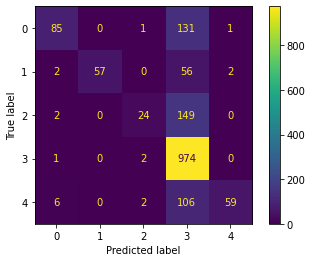

In [0]:
preds_in_pandas = (preds.select(F.col('text').alias("text"), F.col('label').alias("ground_truth"), F.col('class.result').alias("prediction"))).toPandas()

preds_in_pandas['prediction'] = preds_in_pandas['prediction'].apply(lambda x : x[0])

metrics_eval(preds_in_pandas['ground_truth'], preds_in_pandas['prediction'], "CNN News Multiclass Classification")

###### Conversion for the Confusion Matrix:
****
    '0' => 'business'
    '1' => 'entertainment'
    '2' => 'health'
    '3' => 'news'
    '4' => 'politics'
****
* Before I ended the spark session, I forgot to change the function to include the conversion from integer label values to string label values. Thus I have included the quick note here.

##### End Spark Session

In [0]:
spark.stop()

## Notes & Other Takeaways From This Project
****
- I am disappointed with the results of this model. Before running this model, I expected the (overall) recall, precision, and f1-score (overall) values in the 0.88+ range. While the dataset could have been larger, I am sure that it would take a substantial increase in the sample size to attain the overall metrics that I alluded to earlier.
****
- I am working towards annotating all user-defined functions. This project was almost completed prior to my push to annotate projects, so I retrofitted the annotations after the initial development and before I did the final training of the full project. As I wrap up this project, I noticed that I forgot a few, but since it took awhile to train and I know how I would fix them, I am going to continue to the next project.
****